# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [11]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

Nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[2]

symbols_list = Nifty50['Symbol'].unique().tolist()
symbols_list = [symbol + '.NS' for symbol in symbols_list]
end_date = '2024-09-14'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  50 of 50 completed


Price                        adj close         close          high  \
date       ticker                                                    
2016-09-16 ADANIENT.NS       36.859791     37.652676     39.505341   
           ADANIPORTS.NS    259.295929    271.149994    275.000000   
           APOLLOHOSP.NS   1269.138062   1305.500000   1319.849976   
           ASIANPAINT.NS   1089.465942   1155.150024   1181.250000   
           AXISBANK.NS      593.017395    602.200012    612.400024   
...                                ...           ...           ...   
2024-08-23 TCS.NS          4463.899902   4463.899902   4506.000000   
           TECHM.NS        1598.400024   1598.400024   1616.949951   
           TITAN.NS        3570.000000   3570.000000   3622.850098   
           ULTRACEMCO.NS  11341.799805  11341.799805  11380.000000   
           WIPRO.NS         512.400024    512.400024    521.450012   

Price                              low          open      volume  
date       ticker                                                 
2016-09-16 ADANIENT.NS       37.352978     38.960438  12219607.0  
           ADANIPORTS.NS    267.700012    268.000000   5596231.0  
           APOLLOHOSP.NS   1273.250000   1284.500000    339922.0  
           ASIANPAINT.NS   1152.000000   1173.599976   1136226.0  
           AXISBANK.NS      592.250000    592.250000  19309804.0  
...                                ...           ...         ...  
2024-08-23 TCS.NS          4455.000000   4500.000000   1809253.0  
           TECHM.NS        1593.050049   1613.050049   1020913.0  
           TITAN.NS        3544.000000   3611.449951   1173387.0  
           ULTRACEMCO.NS  11204.450195  11315.000000    258730.0  
           WIPRO.NS         511.350006    519.900024   5638853.0  

[97402 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [12]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                        adj close         close          high  \
date       ticker                                                    
2016-09-16 ADANIENT.NS       36.859791     37.652676     39.505341   
           ADANIPORTS.NS    259.295929    271.149994    275.000000   
           APOLLOHOSP.NS   1269.138062   1305.500000   1319.849976   
           ASIANPAINT.NS   1089.465942   1155.150024   1181.250000   
           AXISBANK.NS      593.017395    602.200012    612.400024   
...                                ...           ...           ...   
2024-08-23 TCS.NS          4463.899902   4463.899902   4506.000000   
           TECHM.NS        1598.400024   1598.400024   1616.949951   
           TITAN.NS        3570.000000   3570.000000   3622.850098   
           ULTRACEMCO.NS  11341.799805  11341.799805  11380.000000   
           WIPRO.NS         512.400024    512.400024    521.450012   

Price                              low          open      volume  \
date       ticker                                                  
2016-09-16 ADANIENT.NS       37.352978     38.960438  12219607.0   
           ADANIPORTS.NS    267.700012    268.000000   5596231.0   
           APOLLOHOSP.NS   1273.250000   1284.500000    339922.0   
           ASIANPAINT.NS   1152.000000   1173.599976   1136226.0   
           AXISBANK.NS      592.250000    592.250000  19309804.0   
...                                ...           ...         ...   
2024-08-23 TCS.NS          4455.000000   4500.000000   1809253.0   
           TECHM.NS        1593.050049   1613.050049   1020913.0   
           TITAN.NS        3544.000000   3611.449951   1173387.0   
           ULTRACEMCO.NS  11204.450195  11315.000000    258730.0   
           WIPRO.NS         511.350006    519.900024   5638853.0   

Price                     garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2016-09-16 ADANIENT.NS            0.000383        NaN       NaN       NaN   
           ADANIPORTS.NS         -0.000059        NaN       NaN       NaN   
           APOLLOHOSP.NS          0.000590        NaN       NaN       NaN   
           ASIANPAINT.NS         -0.001823        NaN       NaN       NaN   
           AXISBANK.NS            0.000559        NaN       NaN       NaN   
...                                    ...        ...       ...       ...   
2024-08-23 TCS.NS                 0.000040  62.995981  8.316041  8.374992   
           TECHM.NS               0.000079  63.828527  7.273278  7.338384   
           TITAN.NS               0.000191  60.602157  8.091687  8.141104   
           ULTRACEMCO.NS          0.000119  50.912314  9.301120  9.345948   
           WIPRO.NS               0.000110  51.046451  6.171986  6.231999   

Price                      bb_high       atr      macd  dollar_volume  
date       ticker                                                      
2016-09-16 ADANIENT.NS         NaN       NaN       NaN     450.412158  
           ADANIPORTS.NS       NaN       NaN       NaN    1451.079916  
           APOLLOHOSP.NS       NaN       NaN       NaN     431.407948  
           ASIANPAINT.NS       NaN       NaN       NaN    1237.879530  
           AXISBANK.NS         NaN       NaN       NaN   11451.049666  
...                            ...       ...       ...            ...  
2024-08-23 TCS.NS         8.433944  1.474187  2.229612    8076.324290  
           TECHM.NS       7.403489  1.257954  1.760371    1631.827364  
           TITAN.NS       8.190521  1.777151  1.134018    4188.991590  
           ULTRACEMCO.NS  9.390776  2.339612 -0.593813    2934.463863  
           WIPRO.NS       6.292012  0.945267 -0.076110    2889.348415  

[97402 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [13]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume     adj close  garman_klass_vol  \
date       ticker                                                         
2016-10-31 ADANIENT.NS       177.194412     35.686249          0.000026   
           ADANIPORTS.NS    1586.092959    293.578674         -0.000375   
           APOLLOHOSP.NS     194.869596   1302.677002         -0.000144   
           ASIANPAINT.NS    1190.327216   1009.063782         -0.001424   
           AXISBANK.NS      5280.826689    479.475494          0.000095   
...                                 ...           ...               ...   
2024-08-31 TCS.NS           9181.682325   4463.899902          0.000040   
           TECHM.NS         3067.703843   1598.400024          0.000079   
           TITAN.NS         4128.044250   3570.000000          0.000191   
           ULTRACEMCO.NS    3491.375396  11341.799805          0.000119   
           WIPRO.NS         2944.408291    512.400024          0.000110   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-10-31 ADANIENT.NS    43.655414  3.569607  3.617693  3.665779 -0.851553   
           ADANIPORTS.NS  67.219211  5.434450  5.571542  5.708633 -0.637891   
           APOLLOHOSP.NS  51.873520  7.148748  7.173977  7.199206 -1.131485   
           ASIANPAINT.NS  28.548647  6.934343  7.004064  7.073784 -0.847063   
           AXISBANK.NS    26.087804  6.179158  6.250608  6.322059 -0.538088   
...                             ...       ...       ...       ...       ...   
2024-08-31 TCS.NS         62.995981  8.316041  8.374992  8.433944  1.474187   
           TECHM.NS       63.828527  7.273278  7.338384  7.403489  1.257954   
           TITAN.NS       60.602157  8.091687  8.141104  8.190521  1.777151   
           ULTRACEMCO.NS  50.912314  9.301120  9.345948  9.390776  2.339612   
           WIPRO.NS       51.046451  6.171986  6.231999  6.292012  0.945267   

                              macd  
date       ticker                   
2016-10-31 ADANIENT.NS   -0.162230  
           ADANIPORTS.NS  0.435055  
           APOLLOHOSP.NS -0.241856  
           ASIANPAINT.NS -0.792834  
           AXISBANK.NS   -1.487757  
...                            ...  
2024-08-31 TCS.NS         2.229612  
           TECHM.NS       1.760371  
           TITAN.NS       1.134018  
           ULTRACEMCO.NS -0.593813  
           WIPRO.NS      -0.076110  

[4723 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [14]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                               
2017-09-30 ADANIENT.NS       62.367619          0.000117  41.236488  4.127846   
           ADANIPORTS.NS    361.466736         -0.000352  43.499214  5.873506   
           APOLLOHOSP.NS    982.374817          0.000691  30.854761  6.873642   
           ASIANPAINT.NS   1071.864502         -0.000953  38.234468  6.981804   
           AXISBANK.NS      506.312408          0.000235  50.979208  6.186463   
...                                ...               ...        ...       ...   
2024-08-31 TCS.NS          4463.899902          0.000040  62.995981  8.316041   
           TECHM.NS        1598.400024          0.000079  63.828527  7.273278   
           TITAN.NS        3570.000000          0.000191  60.602157  8.091687   
           ULTRACEMCO.NS  11341.799805          0.000119  50.912314  9.301120   
           WIPRO.NS         512.400024          0.000110  51.046451  6.171986   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2017-09-30 ADANIENT.NS    4.231364  4.334883 -0.818264 -0.181658  
           ADANIPORTS.NS  5.932039  5.990572 -0.785380 -0.414903  
           APOLLOHOSP.NS  6.942709  7.011777 -1.143737 -0.775126  
           ASIANPAINT.NS  7.045842  7.109879 -1.154875 -0.307387  
           AXISBANK.NS    6.224496  6.262530 -1.271016 -0.047967  
...                            ...       ...       ...       ...  
2024-08-31 TCS.NS         8.374992  8.433944  1.474187  2.229612  
           TECHM.NS       7.338384  7.403489  1.257954  1.760371  
           TITAN.NS       8.141104  8.190521  1.777151  1.134018  
           ULTRACEMCO.NS  9.345948  9.390776  2.339612 -0.593813  
           WIPRO.NS       6.231999  6.292012  0.945267 -0.076110  

[4173 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [15]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                               
2018-09-30 ADANIENT.NS      128.936584          0.004837  47.755608  4.847757   
           ADANIPORTS.NS    317.148499         -0.000246  30.729024  5.768484   
           APOLLOHOSP.NS   1023.402832          0.000411  45.234480  6.899753   
           ASIANPAINT.NS   1233.472534         -0.000609  42.017322  7.087634   
           AXISBANK.NS      609.832275          0.000764  50.783396  6.379411   
...                                ...               ...        ...       ...   
2024-08-31 TCS.NS          4463.899902          0.000040  62.995981  8.316041   
           TECHM.NS        1598.400024          0.000079  63.828527  7.273278   
           TITAN.NS        3570.000000          0.000191  60.602157  8.091687   
           ULTRACEMCO.NS  11341.799805          0.000119  50.912314  9.301120   
           WIPRO.NS         512.400024          0.000110  51.046451  6.171986   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2018-09-30 ADANIENT.NS    4.962925  5.078093 -0.659648 -0.139812  -0.096351   
           ADANIPORTS.NS  5.870560  5.972636 -0.280231 -0.972140  -0.141590   
           APOLLOHOSP.NS  6.990360  7.080966 -0.763570 -0.468953  -0.114760   
           ASIANPAINT.NS  7.131480  7.175325 -0.506135 -0.767257  -0.057671   
           AXISBANK.NS    6.437561  6.495712  0.669275 -0.264530  -0.055448   
...                            ...       ...       ...       ...        ...   
2024-08-31 TCS.NS         8.374992  8.433944  1.474187  2.229612   0.017912   
           TECHM.NS       7.338384  7.403489  1.257954  1.760371   0.028307   
           TITAN.NS       8.141104  8.190521  1.777151  1.134018   0.032105   
           ULTRACEMCO.NS  9.345948  9.390776  2.339612 -0.593813  -0.045881   
           WIPRO.NS       6.231999  6.292012  0.945267 -0.076110  -0.018391   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2018-09-30 ADANIENT.NS     0.020503   0.217476   0.074303   0.041777   
           ADANIPORTS.NS  -0.092937  -0.039594  -0.011401  -0.022489   
           APOLLOHOSP.NS   0.048750  -0.000152  -0.002787  -0.015480   
           ASIANPAINT.NS  -0.056035   0.007548   0.025012   0.012836   
           AXISBANK.NS     0.055552   0.062826   0.031036   0.009355   
...                             ...        ...        ...        ...   
2024-08-31 TCS.NS          0.070527   0.068188   0.016094   0.029424   
           TECHM.NS        0.066861   0.098416   0.041733   0.032487   
           TITAN.NS        0.024063   0.033782  -0.001974   0.002866   
           ULTRACEMCO.NS  -0.011154   0.047880   0.024058   0.026658   
           WIPRO.NS       -0.002382   0.053527  -0.002003   0.024480   

                          return_12m  
date       ticker                     
2018-09-30 ADANIENT.NS      0.062392  
           ADANIPORTS.NS   -0.010841  
           APOLLOHOSP.NS    0.003415  
           ASIANPAINT.NS    0.011772  
           AXISBANK.NS      0.015623  
...                              ...  
2024-08-31 TCS.NS           0.025469  
           TECHM.NS         0.026524  
           TITAN.NS         0.011988  
           ULTRACEMCO.NS    0.026894  
           WIPRO.NS         0.019266  

[3573 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [16]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2018-09-30 ADANIENT.NS    0.0006 -0.0249 -0.0170  0.0063  0.0129  -0.096351
           ADANIPORTS.NS  0.0006 -0.0249 -0.0170  0.0063  0.0129  -0.141590
           APOLLOHOSP.NS  0.0006 -0.0249 -0.0170  0.0063  0.0129  -0.114760
           ASIANPAINT.NS  0.0006 -0.0249 -0.0170  0.0063  0.0129  -0.057671
           AXISBANK.NS    0.0006 -0.0249 -0.0170  0.0063  0.0129  -0.055448
...                          ...     ...     ...     ...     ...        ...
2024-06-30 TCS.NS         0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.063526
           TECHM.NS       0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.164353
           TITAN.NS       0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.053499
           ULTRACEMCO.NS  0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.176733
           WIPRO.NS       0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.174920

[3473 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [17]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2018-09-30 ADANIENT.NS    0.0006 -0.0249 -0.0170  0.0063  0.0129  -0.096351
           ADANIPORTS.NS  0.0006 -0.0249 -0.0170  0.0063  0.0129  -0.141590
           APOLLOHOSP.NS  0.0006 -0.0249 -0.0170  0.0063  0.0129  -0.114760
           ASIANPAINT.NS  0.0006 -0.0249 -0.0170  0.0063  0.0129  -0.057671
           AXISBANK.NS    0.0006 -0.0249 -0.0170  0.0063  0.0129  -0.055448
...                          ...     ...     ...     ...     ...        ...
2024-06-30 TCS.NS         0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.063526
           TECHM.NS       0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.164353
           TITAN.NS       0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.053499
           ULTRACEMCO.NS  0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.176733
           WIPRO.NS       0.0278 -0.0433 -0.0331  0.0049 -0.0182   0.174920

[3473 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [18]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2018-09-30 ADANIENT.NS         NaN       NaN       NaN       NaN       NaN
           ADANIPORTS.NS       NaN       NaN       NaN       NaN       NaN
           APOLLOHOSP.NS       NaN       NaN       NaN       NaN       NaN
           ASIANPAINT.NS       NaN       NaN       NaN       NaN       NaN
           AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2024-06-30 TCS.NS         0.484252  0.209954 -0.096705 -0.167128  0.309194
           TECHM.NS       0.412721 -0.579557  0.533777 -0.418187 -0.790149
           TITAN.NS       0.478261 -0.744346  0.543090 -0.893601 -0.522264
           ULTRACEMCO.NS  0.606403  0.254120 -0.104211 -0.034603 -0.033864
           WIPRO.NS       0.578762 -0.317423 -0.068257 -1.018879  0.265320

[3473 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [19]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3573 entries, (Timestamp('2018-09-30 00:00:00'), 'ADANIENT.NS') to (Timestamp('2024-08-31 00:00:00'), 'WIPRO.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  3573 non-null   float64
 1   rsi               3573 non-null   float64
 2   bb_low            3573 non-null   float64
 3   bb_mid            3573 non-null   float64
 4   bb_high           3573 non-null   float64
 5   atr               3573 non-null   float64
 6   macd              3573 non-null   float64
 7   return_1m         3573 non-null   float64
 8   return_2m         3573 non-null   float64
 9   return_3m         3573 non-null   float64
 10  return_6m         3573 non-null   float64
 11  return_9m         3573 non-null   float64
 12  return_12m        3573 non-null   float64
 13  Mkt-RF            3573 non-null   float64
 14  SMB               3573 non-null   float64
 15 

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [20]:
from sklearn.cluster import KMeans

# Check if 'cluster' column exists before dropping it
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

# Ensure initial_centroids is defined
initial_centroids = data.sample(n=4, random_state=0).values

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

# Drop missing values and apply clustering
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2018-09-30 ADANIENT.NS            0.004837  47.755608  4.847757  4.962925   
           ADANIPORTS.NS         -0.000246  30.729024  5.768484  5.870560   
           APOLLOHOSP.NS          0.000411  45.234480  6.899753  6.990360   
           ASIANPAINT.NS         -0.000609  42.017322  7.087634  7.131480   
           AXISBANK.NS            0.000764  50.783396  6.379411  6.437561   
...                                    ...        ...       ...       ...   
2024-08-31 TCS.NS                 0.000040  62.995981  8.316041  8.374992   
           TECHM.NS               0.000079  63.828527  7.273278  7.338384   
           TITAN.NS               0.000191  60.602157  8.091687  8.141104   
           ULTRACEMCO.NS          0.000119  50.912314  9.301120  9.345948   
           WIPRO.NS               0.000110  51.046451  6.171986  6.231999   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2018-09-30 ADANIENT.NS    5.078093 -0.659648 -0.139812  -0.096351   0.020503   
           ADANIPORTS.NS  5.972636 -0.280231 -0.972140  -0.141590  -0.092937   
           APOLLOHOSP.NS  7.080966 -0.763570 -0.468953  -0.114760   0.048750   
           ASIANPAINT.NS  7.175325 -0.506135 -0.767257  -0.057671  -0.056035   
           AXISBANK.NS    6.495712  0.669275 -0.264530  -0.055448   0.055552   
...                            ...       ...       ...        ...        ...   
2024-08-31 TCS.NS         8.433944  1.474187  2.229612   0.017912   0.070527   
           TECHM.NS       7.403489  1.257954  1.760371   0.028307   0.066861   
           TITAN.NS       8.190521  1.777151  1.134018   0.032105   0.024063   
           ULTRACEMCO.NS  9.390776  2.339612 -0.593813  -0.045881  -0.011154   
           WIPRO.NS       6.292012  0.945267 -0.076110  -0.018391  -0.002382   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2018-09-30 ADANIENT.NS     0.217476   0.074303   0.041777    0.062392   
           ADANIPORTS.NS  -0.039594  -0.011401  -0.022489   -0.010841   
           APOLLOHOSP.NS  -0.000152  -0.002787  -0.015480    0.003415   
           ASIANPAINT.NS   0.007548   0.025012   0.012836    0.011772   
           AXISBANK.NS     0.062826   0.031036   0.009355    0.015623   
...                             ...        ...        ...         ...   
2024-08-31 TCS.NS          0.068188   0.016094   0.029424    0.025469   
           TECHM.NS        0.098416   0.041733   0.032487    0.026524   
           TITAN.NS        0.033782  -0.001974   0.002866    0.011988   
           ULTRACEMCO.NS   0.047880   0.024058   0.026658    0.026894   
           WIPRO.NS        0.053527  -0.002003   0.024480    0.019266   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2018-09-30 ADANIENT.NS    0.280631  0.482438 -0.075901  1.478628 -0.690343   
           ADANIPORTS.NS  0.308356  0.705266  0.253377  0.799279 -0.426678   
           APOLLOHOSP.NS  0.471536 -0.190206  0.249998 -0.449455 -1.373121   
           ASIANPAINT.NS  0.078523  0.439013  0.096362  0.823042 -0.404074   
           AXISBANK.NS    0.847630  0.195860  0.682412 -0.331793 -0.006377   
...                            ...       ...       ...       ...       ...   
2024-08-31 TCS.NS         0.303290  0.391724 -0.177715  0.128999  0.414900   
           TECHM.NS       0.885759 -0.494216  0.077109 -0.231403 -0.091077   
           TITAN.NS       0.561075 -0.082767  0.295587 -0.192142 -0.110776   
           ULTRACEMCO.NS  0.428623  0.257832  0.463494  0.226586 -0.931725   
           WIPRO.NS       0.608132 -0.222515  0.039931 -0.542021 -0.246626   

                  

In [21]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


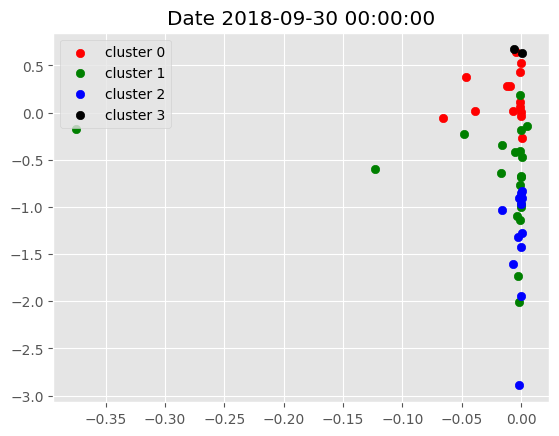

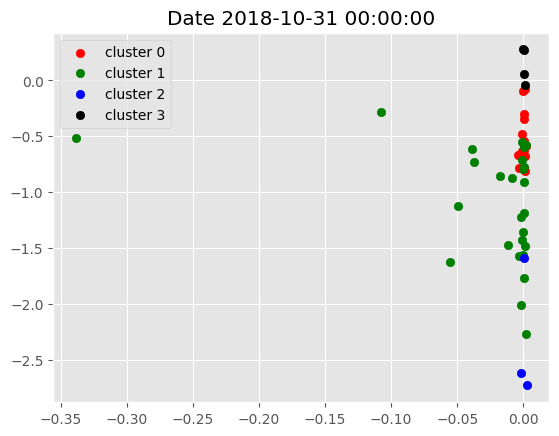

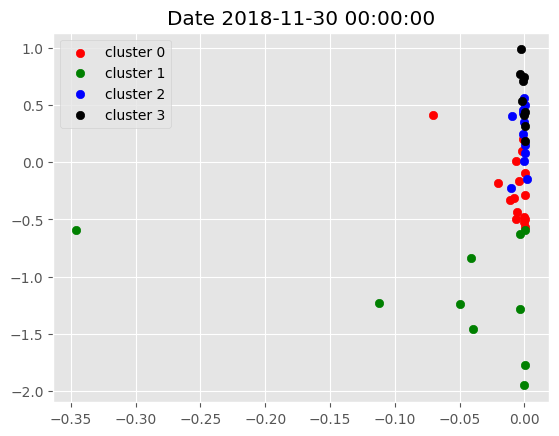

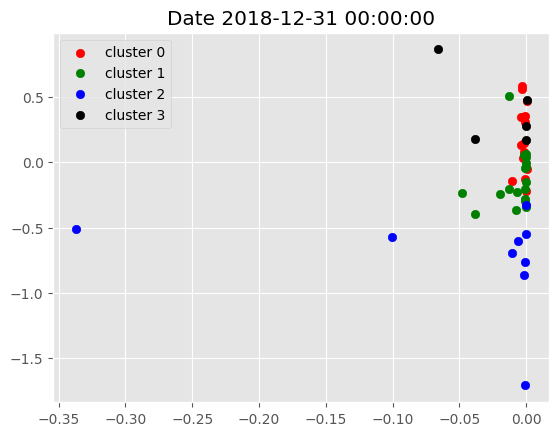

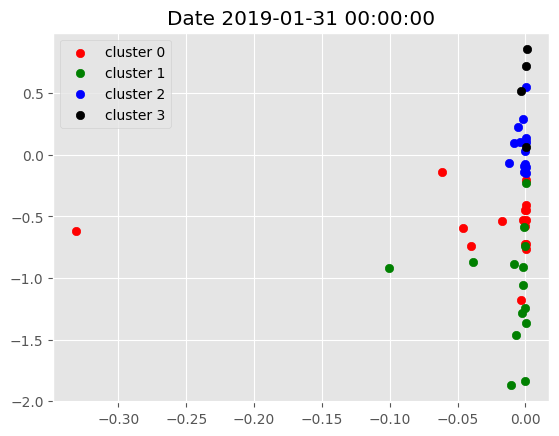

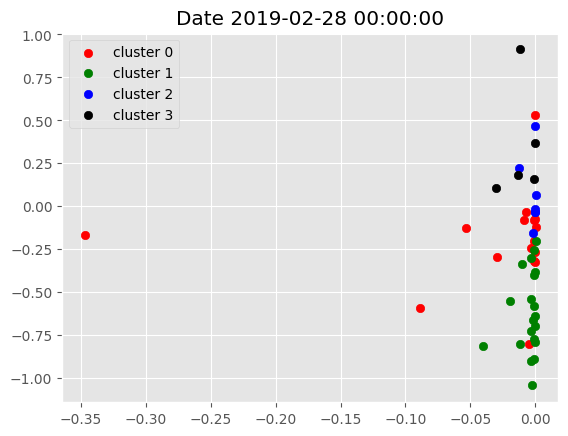

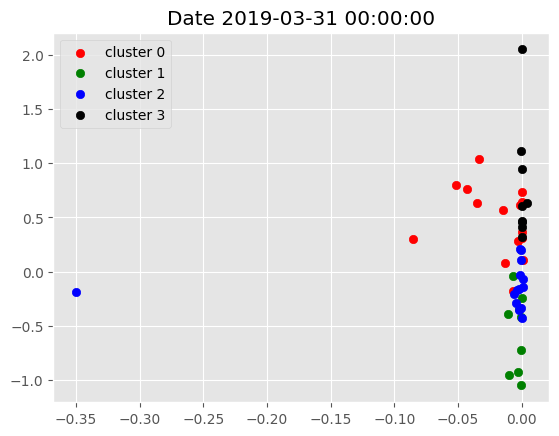

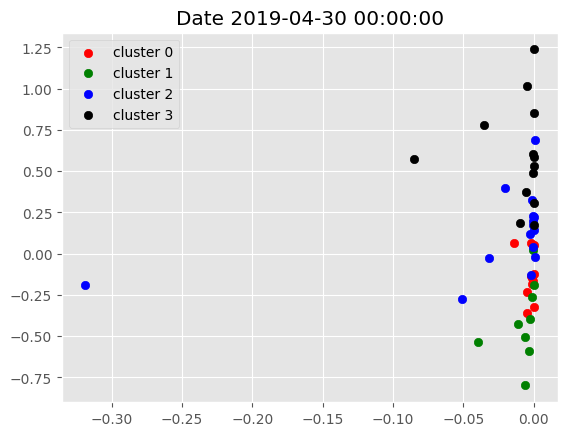

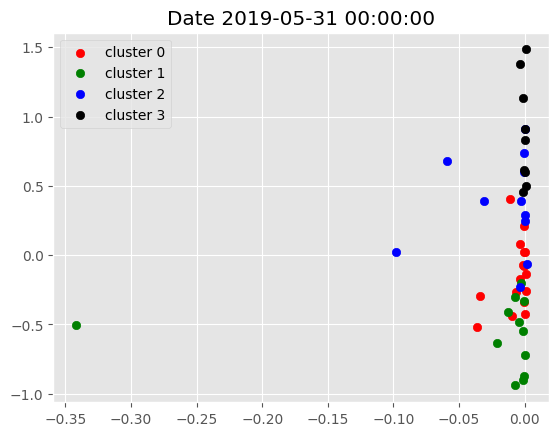

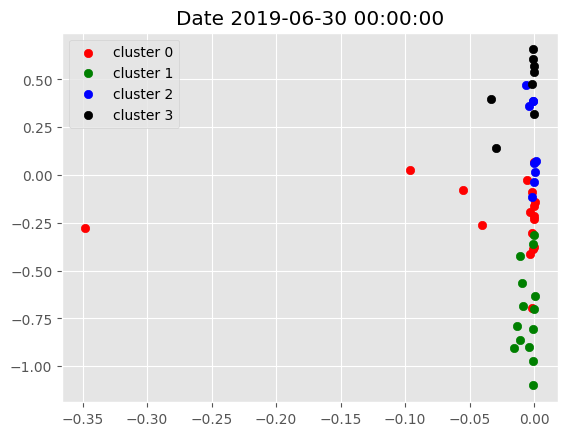

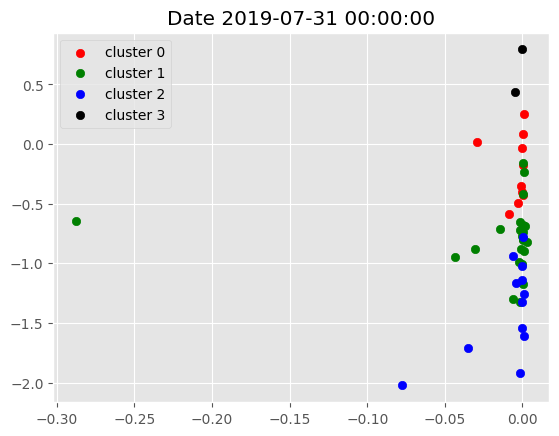

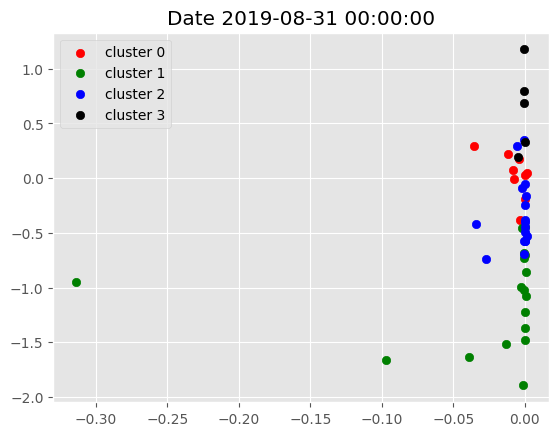

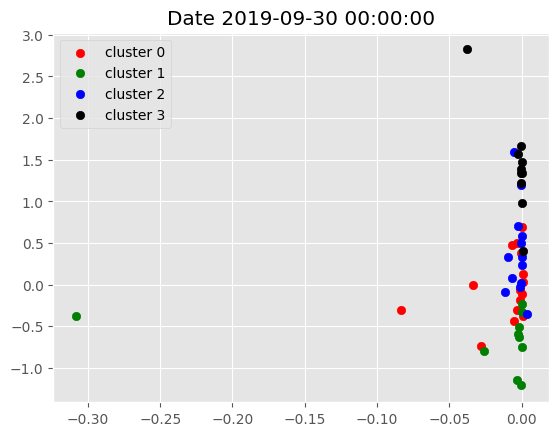

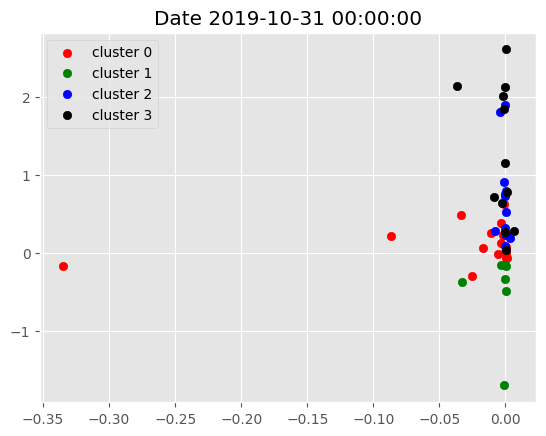

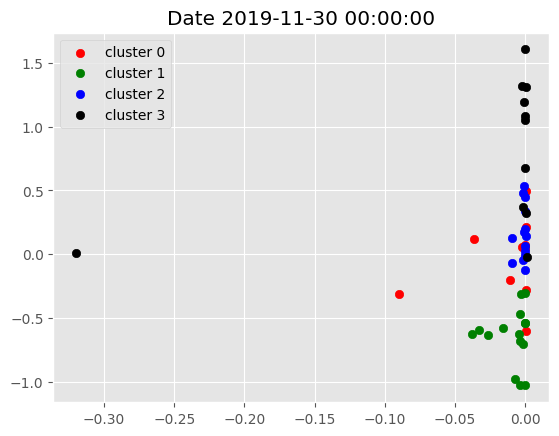

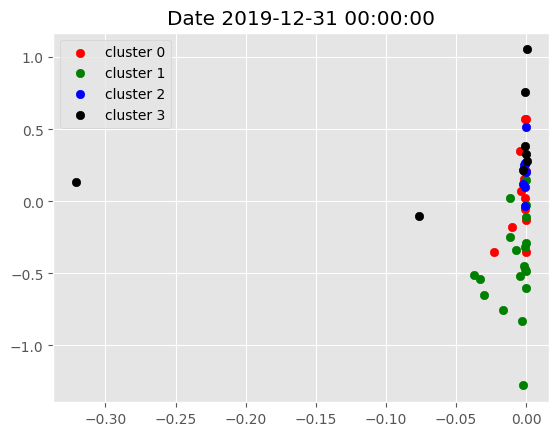

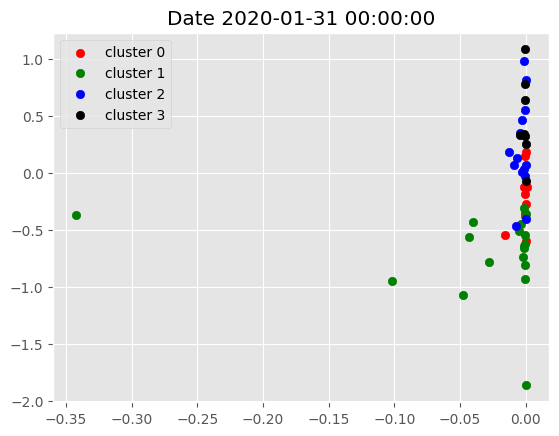

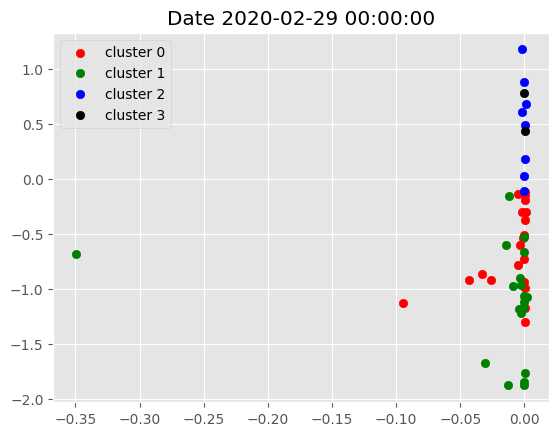

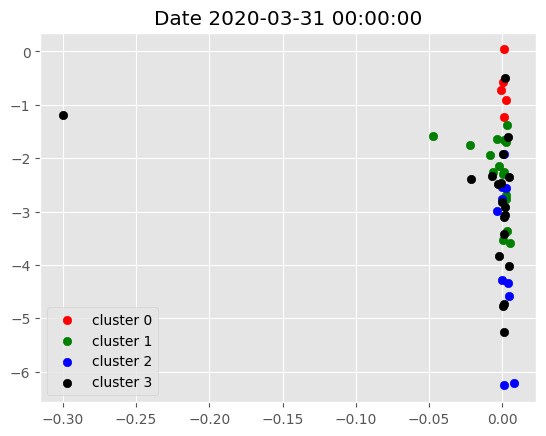

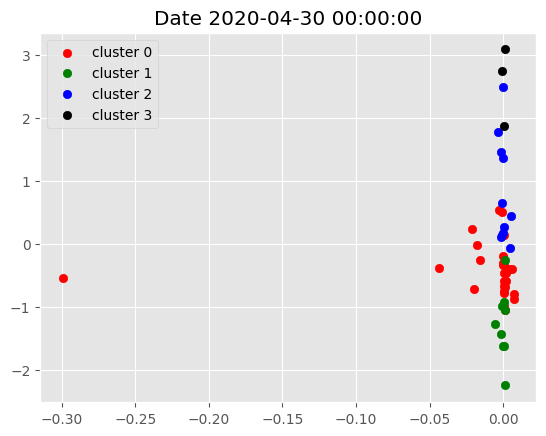

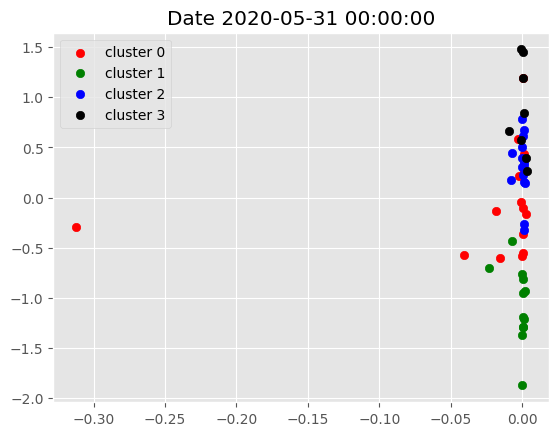

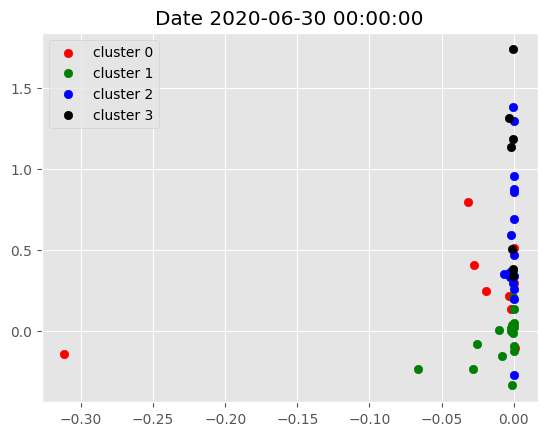

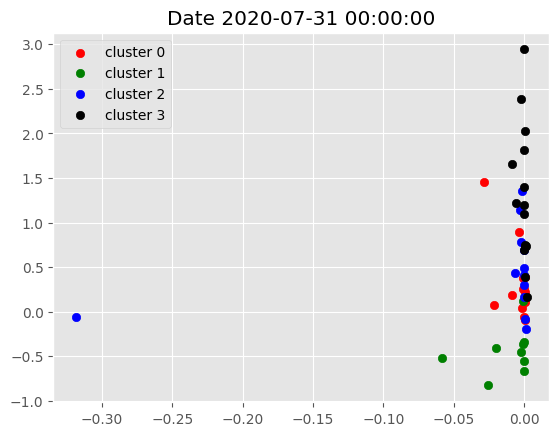

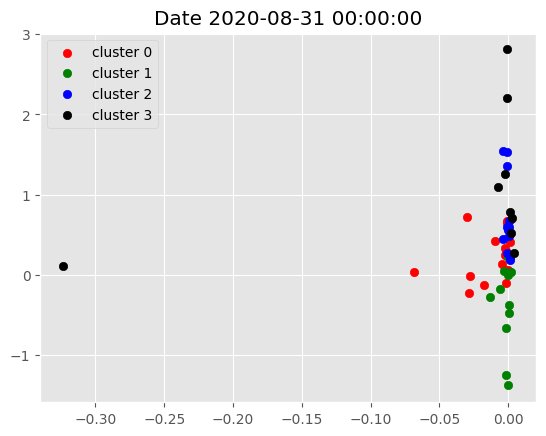

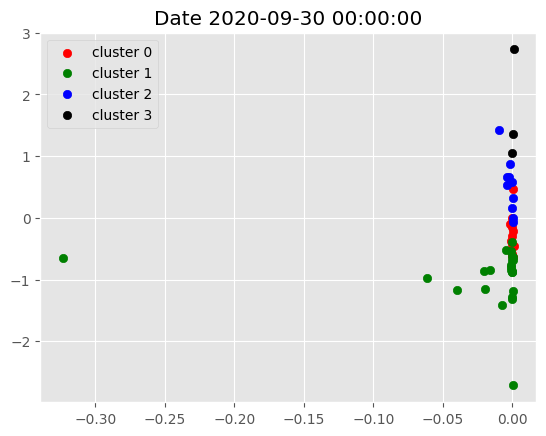

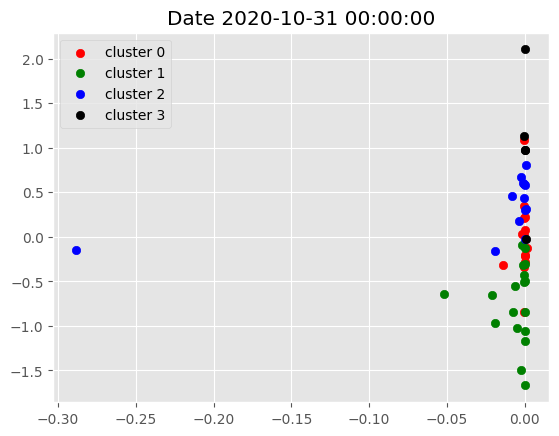

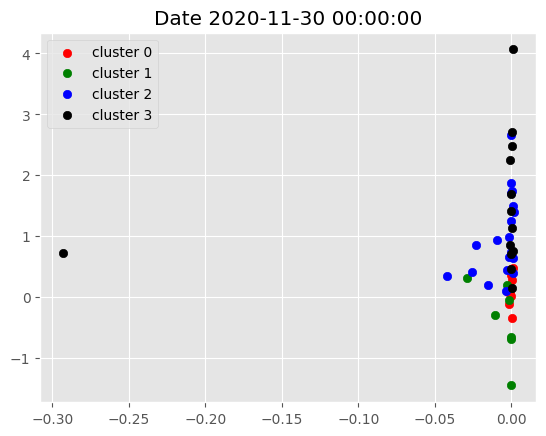

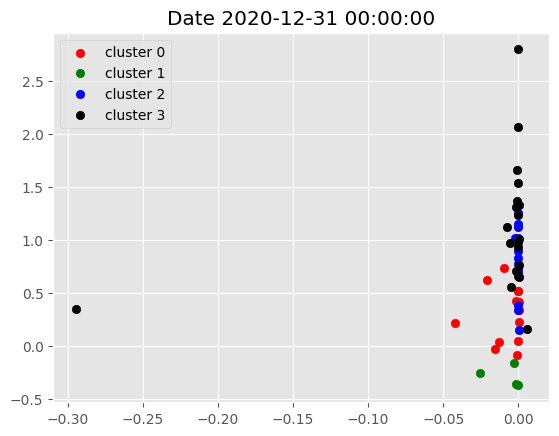

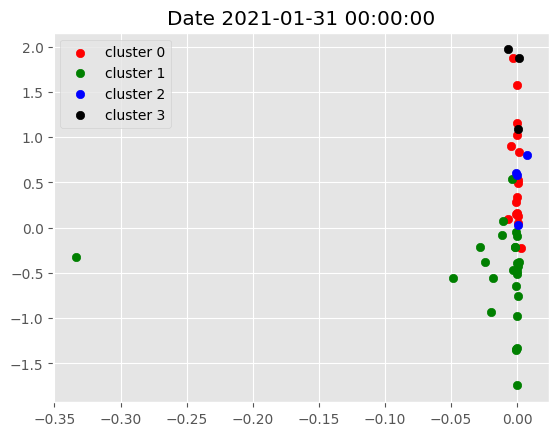

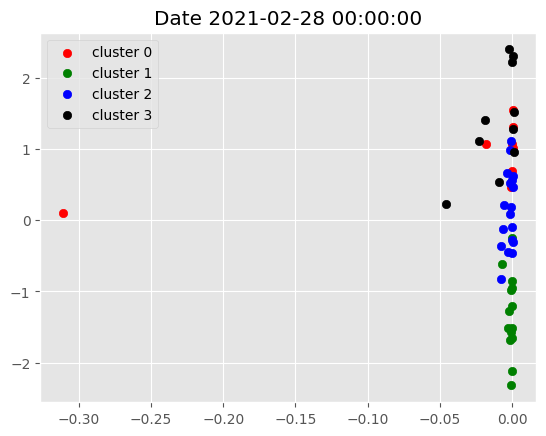

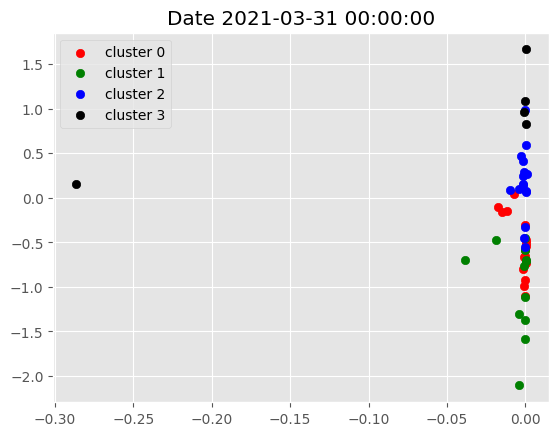

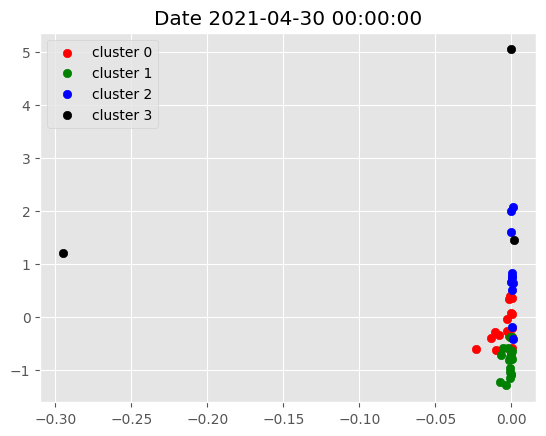

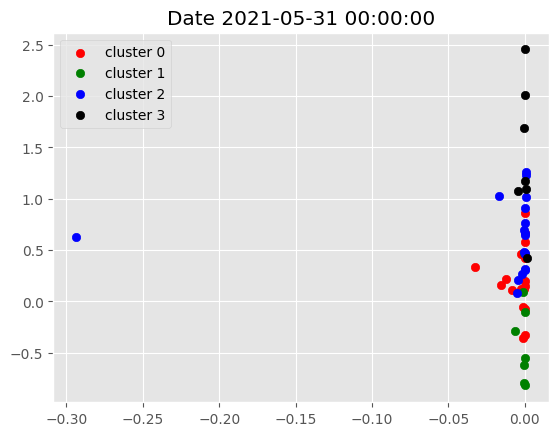

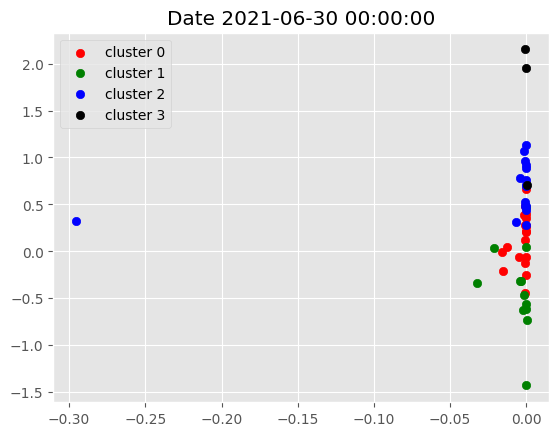

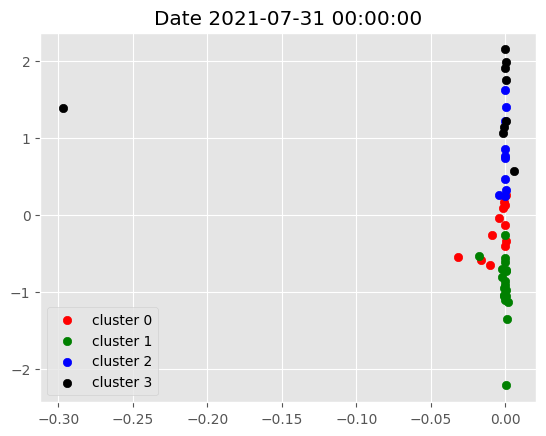

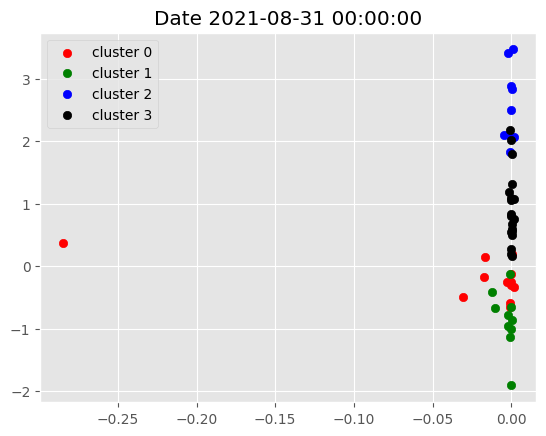

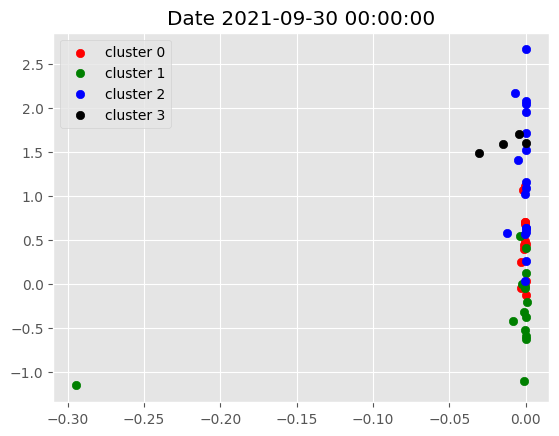

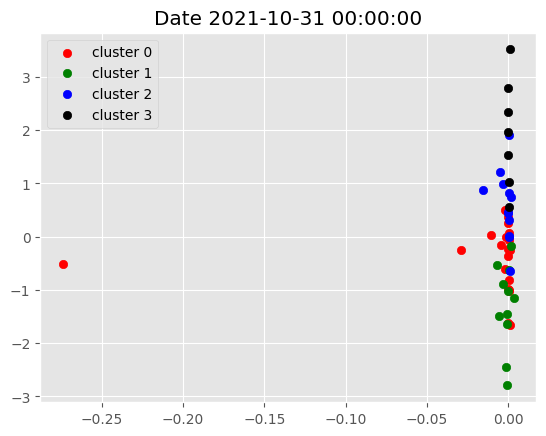

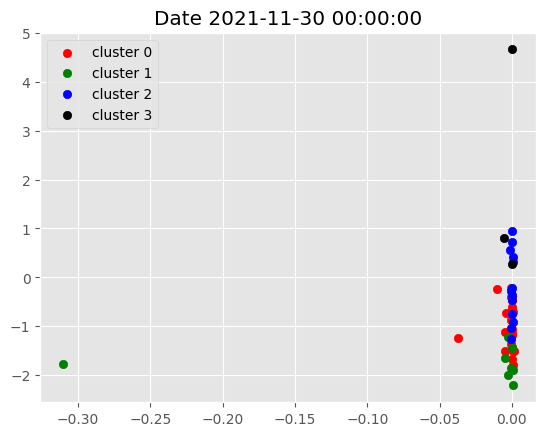

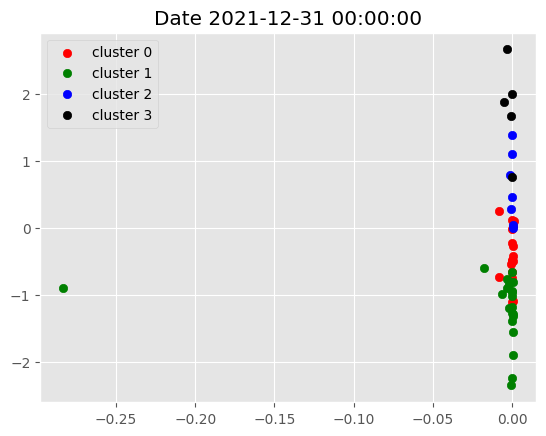

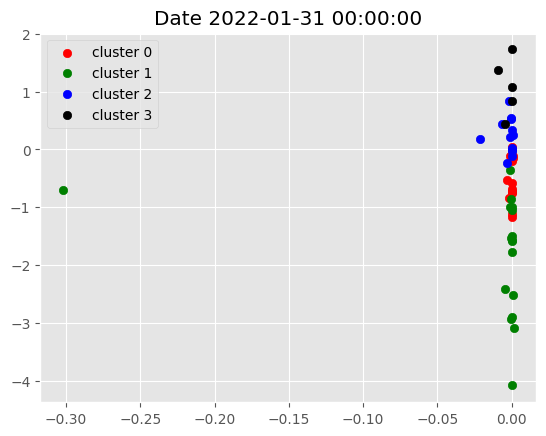

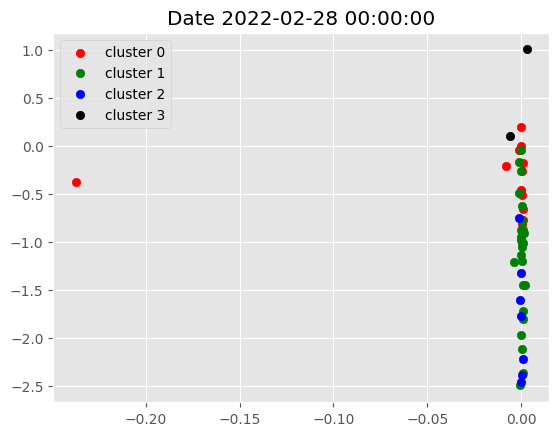

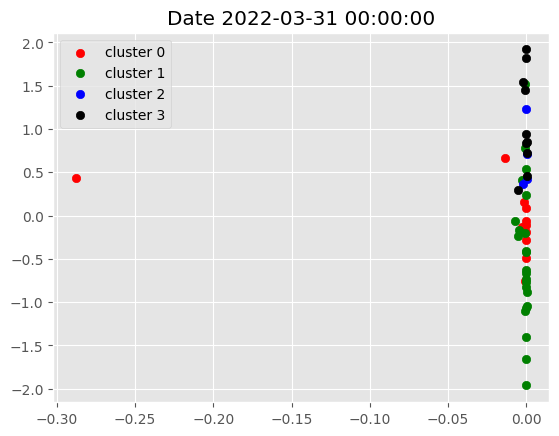

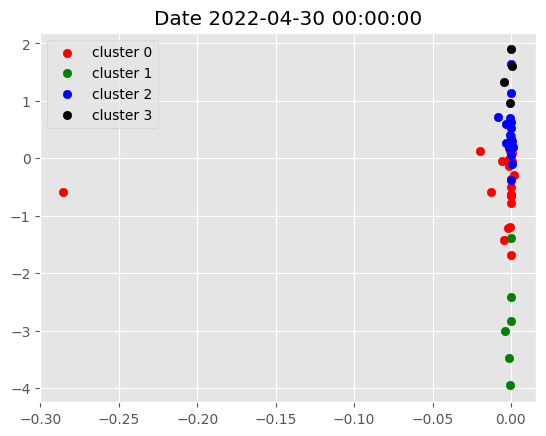

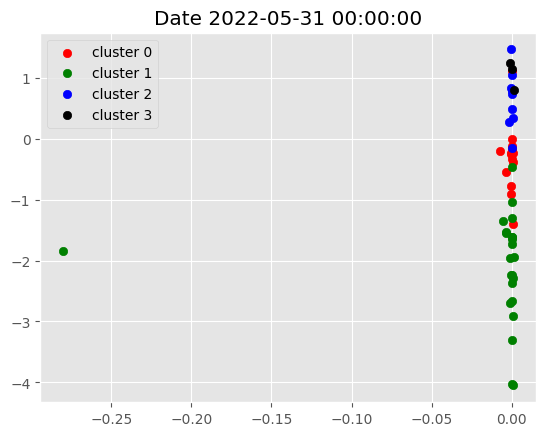

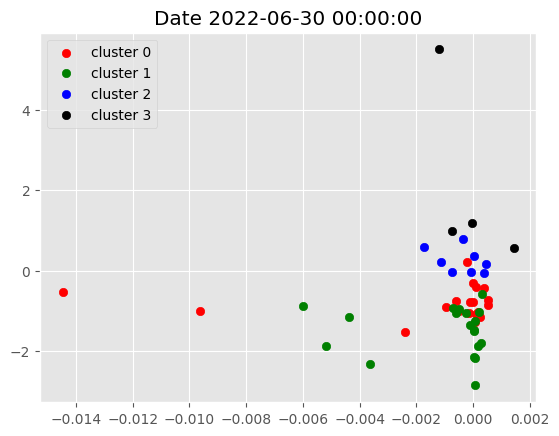

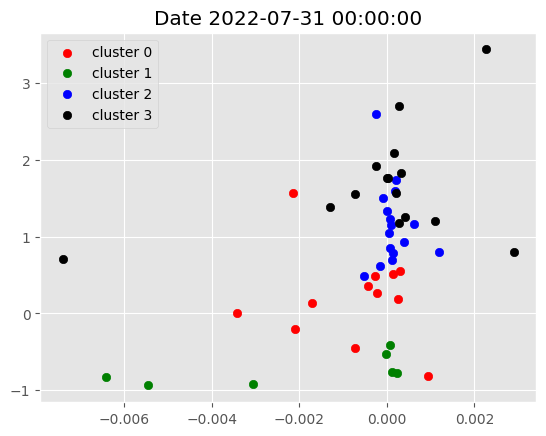

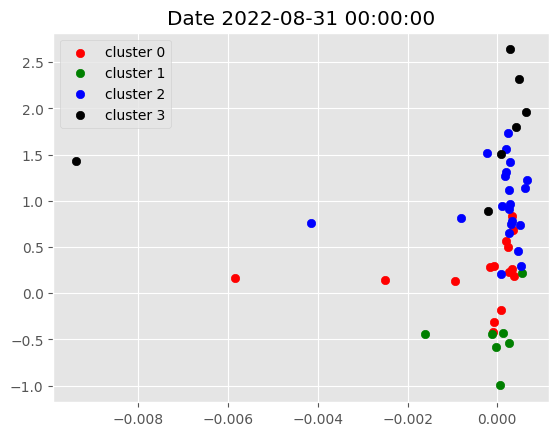

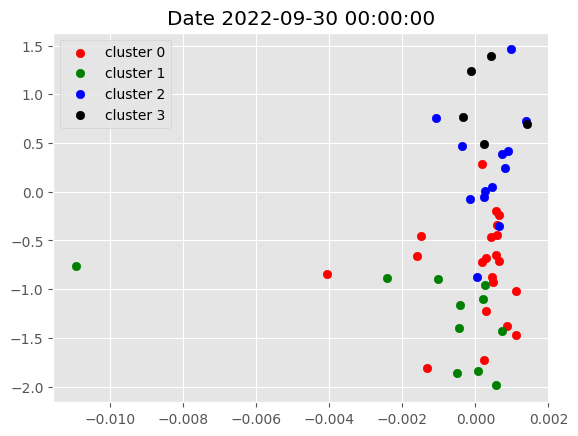

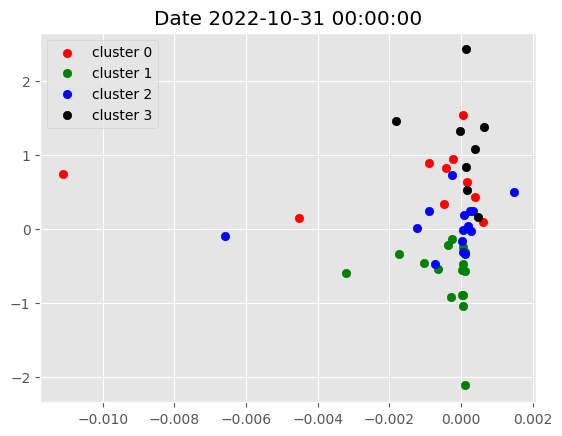

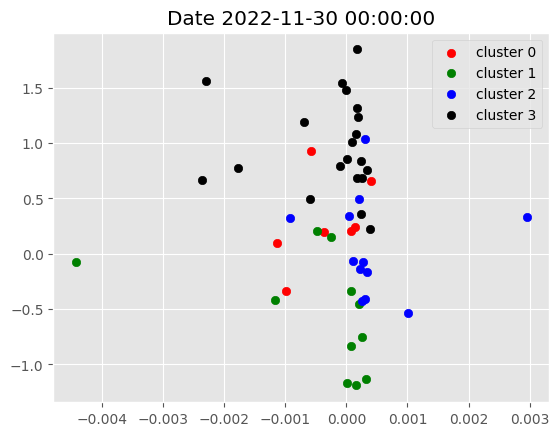

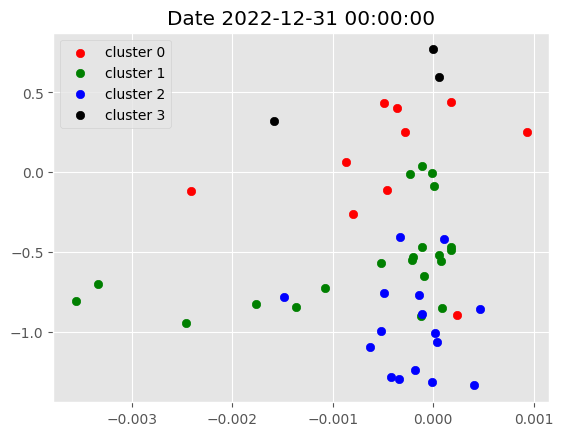

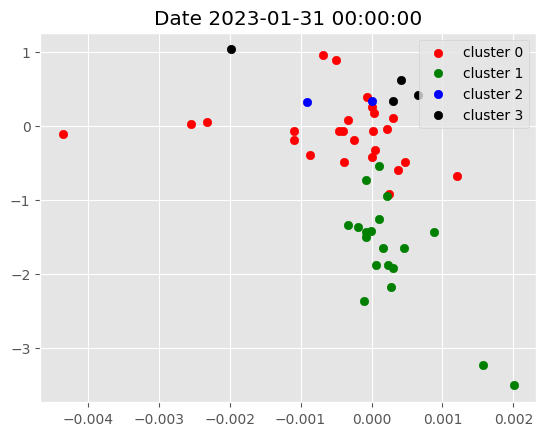

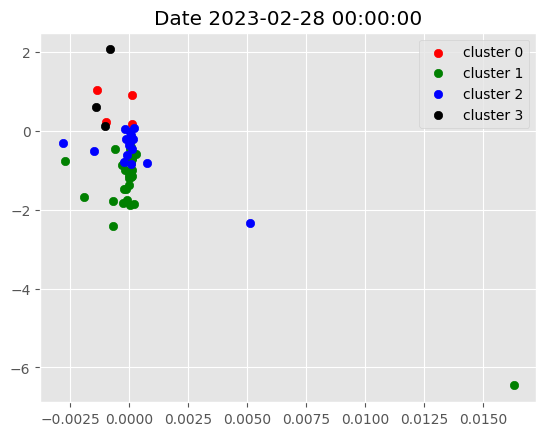

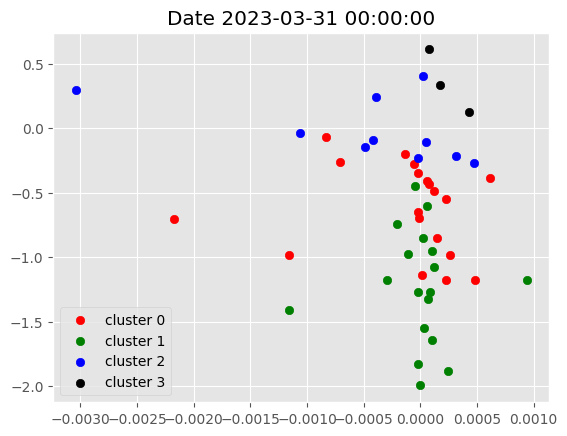

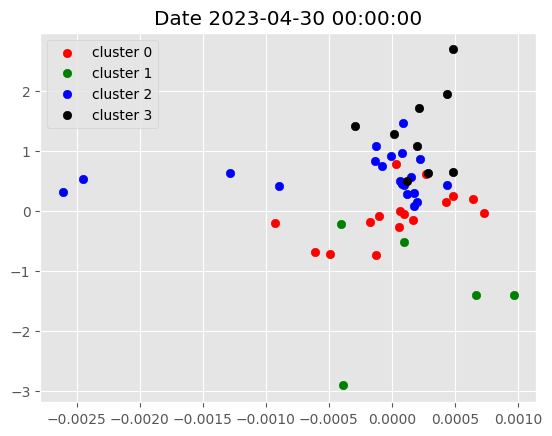

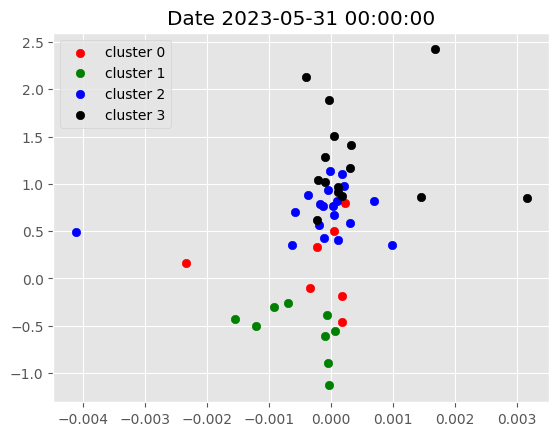

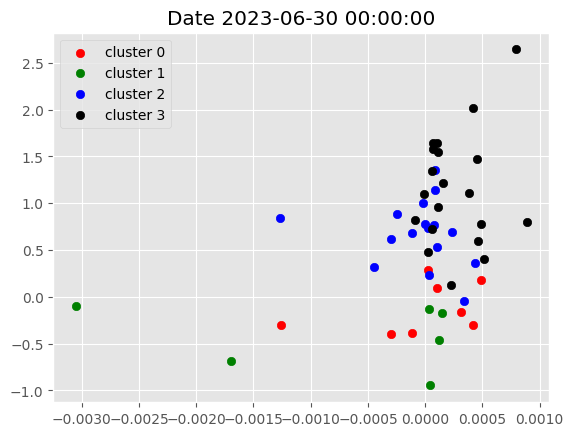

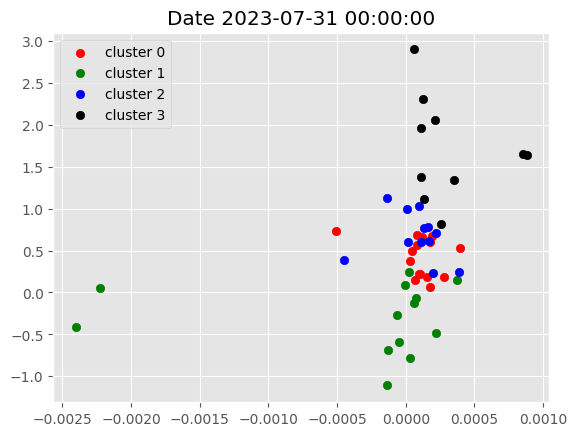

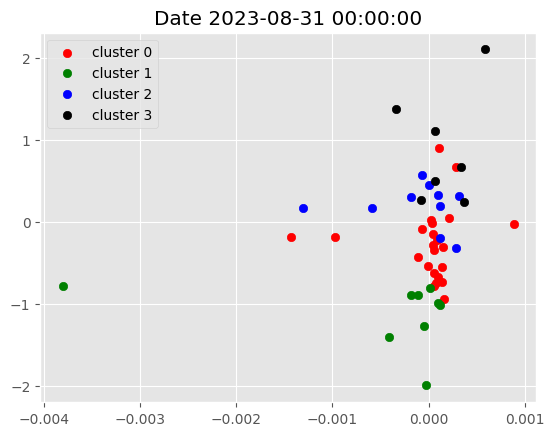

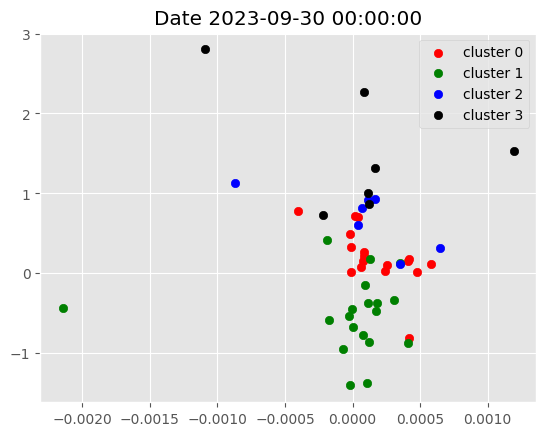

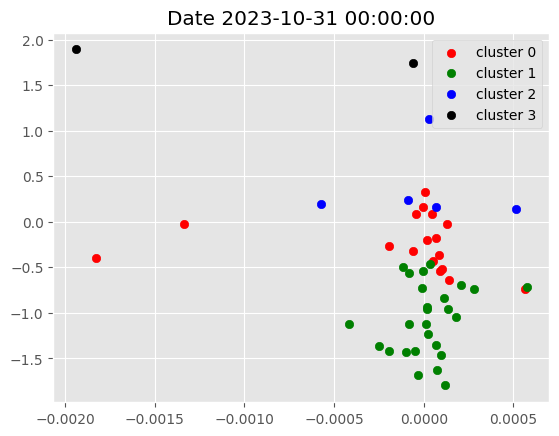

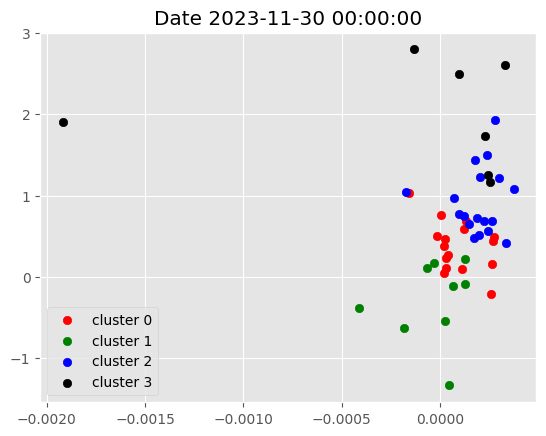

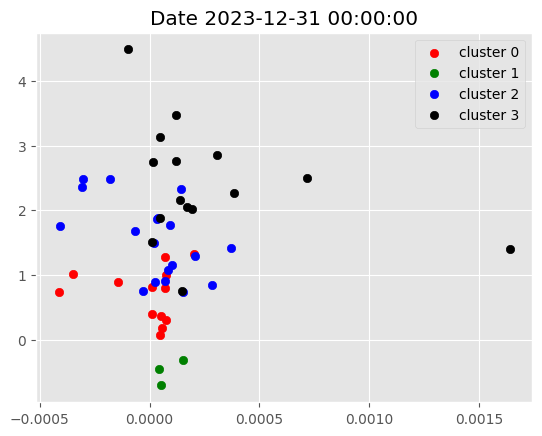

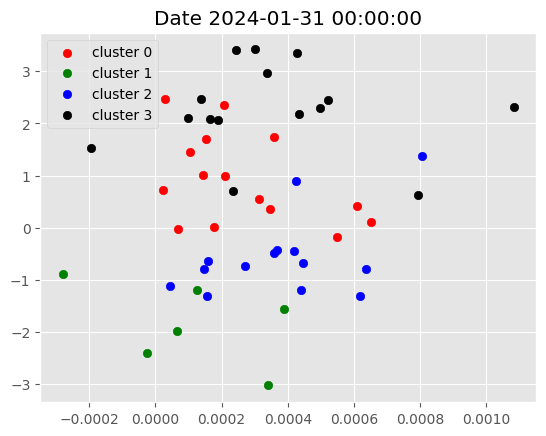

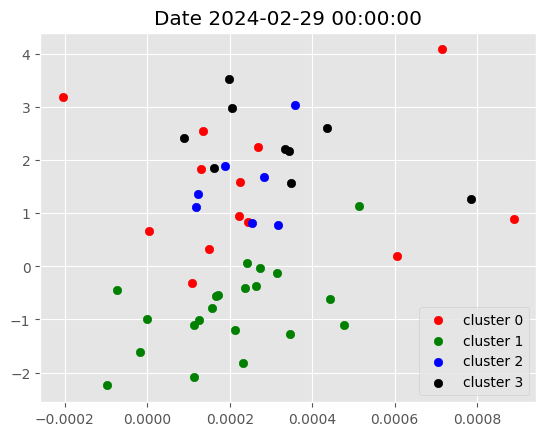

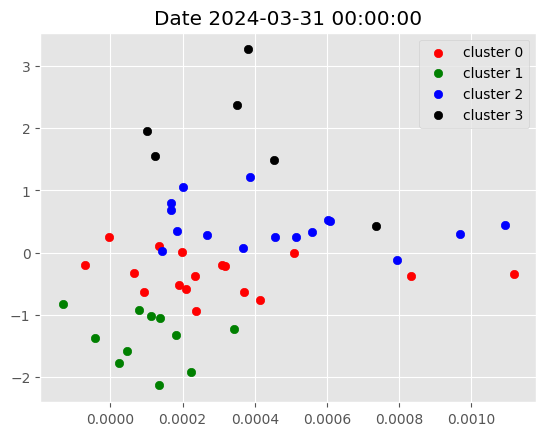

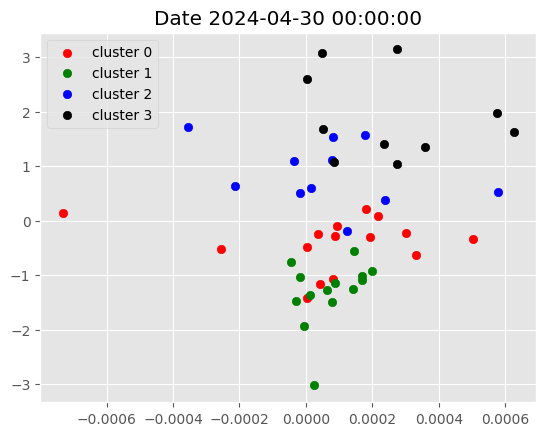

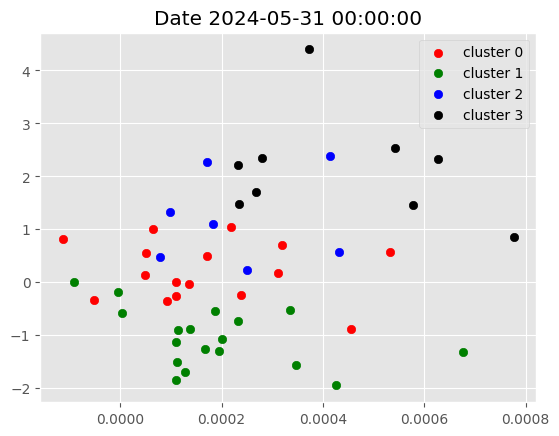

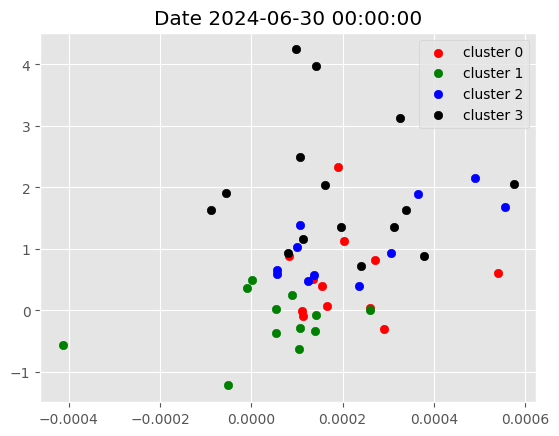

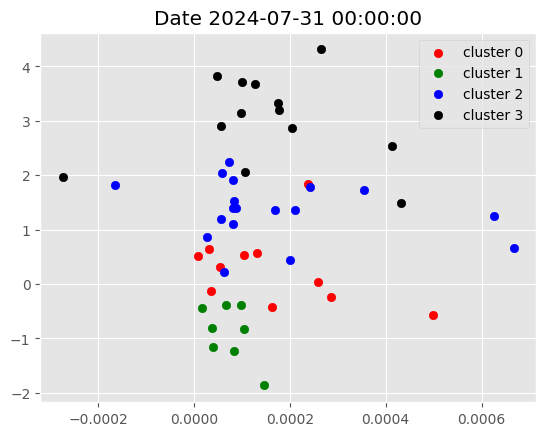

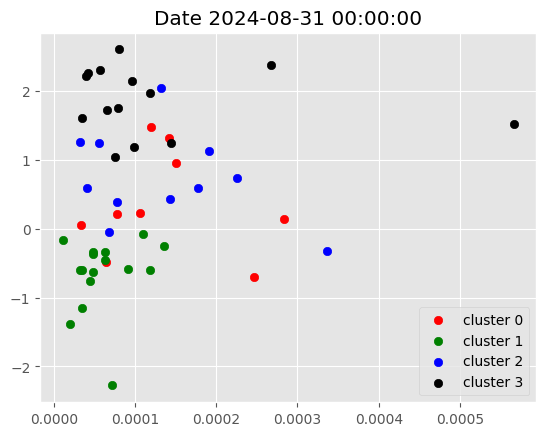

In [22]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [23]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [24]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-10-01': ['TCS.NS', 'WIPRO.NS'],
 '2018-11-01': ['ADANIENT.NS', 'DIVISLAB.NS', 'ICICIBANK.NS', 'WIPRO.NS'],
 '2018-12-01': ['APOLLOHOSP.NS',
  'BRITANNIA.NS',
  'DRREDDY.NS',
  'HDFCBANK.NS',
  'HINDUNILVR.NS',
  'KOTAKBANK.NS',
  'LT.NS',
  'NESTLEIND.NS',
  'TITAN.NS'],
 '2019-01-01': ['ADANIPORTS.NS',
  'BAJAJFINSV.NS',
  'BAJFINANCE.NS',
  'BPCL.NS',
  'POWERGRID.NS'],
 '2019-02-01': ['AXISBANK.NS', 'INFY.NS', 'TITAN.NS', 'WIPRO.NS'],
 '2019-03-01': ['BAJAJ-AUTO.NS',
  'CIPLA.NS',
  'DIVISLAB.NS',
  'ONGC.NS',
  'TECHM.NS'],
 '2019-04-01': ['ASIANPAINT.NS',
  'AXISBANK.NS',
  'BAJAJFINSV.NS',
  'BAJFINANCE.NS',
  'HDFCBANK.NS',
  'ICICIBANK.NS',
  'INDUSINDBK.NS',
  'SBIN.NS',
  'TITAN.NS'],
 '2019-05-01': ['BAJAJFINSV.NS',
  'BAJFINANCE.NS',
  'COALINDIA.NS',
  'DRREDDY.NS',
  'GRASIM.NS',
  'HCLTECH.NS',
  'KOTAKBANK.NS',
  'ONGC.NS',
  'TCS.NS',
  'TECHM.NS',
  'TITAN.NS',
  'ULTRACEMCO.NS',
  'WIPRO.NS'],
 '2019-06-01': ['AXISBANK.NS',
  'BAJAJFINSV.NS',
  'BAJFINANCE.NS'

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [25]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [26]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  50 of 50 completed


Price         Adj Close                                            \
Ticker      ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS   
Date                                                                
2017-10-03    59.954422    368.134827   1029.636230   1088.060669   
2017-10-04    61.831352    371.924591   1025.628662   1093.033081   
2017-10-05    65.209831    370.245544   1056.224121   1092.275024   
2017-10-06    66.201904    373.459625   1039.557983   1096.111206   
2017-10-09    63.976406    377.729156   1028.756348   1097.342407   
...                 ...           ...           ...           ...   
2024-08-19  3102.550049   1496.449951   6724.899902   3076.300049   
2024-08-20  3070.649902   1492.550049   6672.899902   3103.199951   
2024-08-21  3115.699951   1503.500000   6752.450195   3151.550049   
2024-08-22  3099.050049   1492.300049   6830.549805   3186.600098   
2024-08-23  3076.350098   1491.300049   6860.700195   3154.649902   

Price                                                              \
Ticker      AXISBANK.NS BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS   
Date                                                                
2017-10-03   506.809601   2600.645264    530.982727   1830.337280   
2017-10-04   503.130219   2609.938477    525.902771   1825.290527   
2017-10-05   498.406738   2574.821533    524.327332   1828.769287   
2017-10-06   500.544769   2583.662598    528.240784   1885.017944   
2017-10-09   503.130219   2570.421631    529.023560   1902.362793   
...                 ...           ...           ...           ...   
2024-08-19  1153.250000   9770.650391   1551.099976   6616.350098   
2024-08-20  1168.000000   9779.700195   1602.099976   6722.200195   
2024-08-21  1174.400024   9852.000000   1620.949951   6735.350098   
2024-08-22  1169.949951   9914.200195   1625.699951   6743.600098   
2024-08-23  1165.949951  10406.450195   1639.900024   6735.850098   

Price                                 ...        Volume               \
Ticker     BHARTIARTL.NS     BPCL.NS  ... SHRIRAMFIN.NS SUNPHARMA.NS   
Date                                  ...                              
2017-10-03    333.255219  150.068481  ...        582748      2880625   
2017-10-04    326.757294  152.356232  ...        493328      6203591   
2017-10-05    327.233826  150.460205  ...        766429      3576059   
2017-10-06    331.219208  153.437439  ...        420487      6323391   
2017-10-09    328.316772  150.820572  ...        670474      5049020   
...                  ...         ...  ...           ...          ...   
2024-08-19   1469.650024  343.799988  ...       1818434      1363446   
2024-08-20   1449.150024  349.399994  ...       2429911      1766597   
2024-08-21   1463.449951  351.200012  ...       1045406      1184193   
2024-08-22   1486.349976  350.100006  ...        922139      1369554   
2024-08-23   1506.750000  352.200012  ...        493393      3515492   

Price                                                                  \
Ticker     TATACONSUM.NS TATAMOTORS.NS TATASTEEL.NS   TCS.NS TECHM.NS   
Date                                                                    
2017-10-03       1985873       9696920     29913418  1923006  1901932   
2017-10-04       1964885       7663143     29226912  1300778  1673214   
2017-10-05       2228532       4606192     16296360  1684686  1237068   
2017-10-06       2534607       5308695     99343423  1389188  1130586   
2017-10-09       1653094       4414381     58978544  1773616   997113   
...                  ...           ...          ...      ...      ...   
2024-08-19        682374       6911441     62889770  2055210  1640507   
2024-08-20        673329       5625723     37559016  2212298  2442281   
2024-08-21        802420       4869876     49749381  1896990  1935929   
2024-08-22       2041300       9377476     36719176  1829872  1562554   
2024-08-23        852159      10179655     31490857  1809253  1020913   

Price                             

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [31]:
import numpy as np
import pandas as pd

# Assuming new_df and fixed_dates are already defined
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df.loc[optimization_start_date:optimization_end_date, 'Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                       lower_bound=round(1 / (len(optimization_df.columns) * 2), 3))
            weights = pd.DataFrame(weights, index=optimization_df.columns, columns=['weight'])
            success = True
        except Exception as e:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights: {e}')

        if not success:
            weights = pd.DataFrame([1 / len(optimization_df.columns) for _ in range(len(optimization_df.columns))],
                                   index=optimization_df.columns, columns=['weight'])

        temp_df = returns_dataframe.loc[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0) \
            .merge(weights, left_index=True, right_index=True) \
            .reset_index().set_index(['Date', 'level_1']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(f"Error processing {start_date}: {e}")

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-10-01, Continuing with Equal-Weights: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing 2018-10-01: "None of ['level_1'] are in the columns"
Max Sharpe Optimization failed for 2018-11-01, Continuing with Equal-Weights: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing 2018-11-01: "None of ['level_1'] are in the columns"
Max Sharpe Optimization failed for 2018-12-01, Continuing with Equal-Weights: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing 2018-12-01: "None of ['level_1'] are in the columns"
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing 2019-01-01: "None of ['level_1'] are in the columns"
Max 

""


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [34]:
spy = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

TypeError: date.today() takes no arguments (1 given)

In [29]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


TypeError: cannot do slice indexing on RangeIndex with these indexers [2023-09-29] of type str